<h1> Red wine data analysis </h1>

<h2>Business Understanding</h2>

Through the business, we have been asked to examine the following questions:

<ol>
<li>In hoeverre is de score van een Portugese Red te voorspellen op basis van de chemische kenmerken?</li>
<li>Zelf te bepalen: denk aan andere type wijnen of andere landen.</li>
<li>Zelf te bepalen: denk bijvoorbeeld aan het clusteren op basis van de chemische kenmerken waarmee het type druif of de regio bepaald kan worden. Of kun je logische clusters vinden van topwijnen, doordrinkwijnen en bocht?</li>
</ol>

<i>TODO(m-jeu): Either translate these questions to english, or change the language of the rest of the document to dutch. This also goes for the dutch list in 'Data Understanding'.</i>

Currently, the exact nature of 'the business' and their desires datascience-wise is unknown to us. This requires further investigation.

<h2> Data Understanding </h2>

The business tells us the most important variables in the dataset are:

<ol>
<li>Herkomst van de wijn en type druif.</li>
<li>Review van de wijn, inclusief naam van de sommelier en de score op een schaal van 1 tot 100.</li>
<li>De uitkomsten van chemische tests op 11 waarde (waaronder suikergehalte, pH, alcoholgehalte, et cetera).</li>



We import some libraries and the dataset to examine the data through code.

In [455]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [431]:
dataset = pd.read_csv("redwine.csv", sep=";")

A first look at the dataset:

In [432]:
dataset.head(5)

,id,country,description,designation,points,price,province,taster_name,title,variety,...,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Kerin O�Keefe,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,...,0.29,0.4,2.9,0.098,10.0,26.0,10.006,3.48,0.91,9.7
1,2,Portugal,"From an estate in the south of the Alentejo, t...",Grande Reserva Tinto,91,26.0,Alentejano,Roger Voss,Casa Santa Vit�ria 2013 Grande Reserva Tinto R...,Portuguese Red,...,0.26,0.37,1.4,0.076,8.0,23.0,0.9974,3.26,0.70,9.6
2,3,Portugal,A year in wood and 30 months in bottle before ...,Montes Claros Garrafeira,90,28.0,Alentejo,Paul Gregutt,Adega Cooperativa de Borba 2012 Montes Claros ...,Portuguese Red,...,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
3,4,Portugal,Wood aging gives this ripe blend of Baga and T...,NaN,90,20.0,Beira Atlantico,Alexander Peartree,Quinta de Foz de Arouce 2013 Red (Beira Atlant...,Portuguese Red,...,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
4,5,Portugal,"A powerful wine, richly structured and full of...",Gera��es Colheita Seleccionada,92,34.0,Alentejano,Paul Gregutt,Herdade Grande 2010 Gera��es Colheita Seleccio...,Portuguese Red,...,0.48,0.34,2.2,0.073,16.0,25.0,0.9936,3.28,0.66,12.4


Rows seems to correspond with individual wines on first glance, though this does need to be examined more thoroughly. Columns are different attributes for those individual wines.

<h2>Data Preparation</h2>

The data needs some cleaning up.



<h3>Notebook-wide data-preparation</h3>

An overview of datatypes:

In [433]:
dataset.dtypes

id                        int64
country                  object
description              object
designation              object
points                    int64
price                   float64
province                 object
taster_name              object
title                    object
variety                  object
winery                   object
fixed acidity           float64
volatile acidity        float64
citric acid              object
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                  object
pH                      float64
sulphates               float64
alcohol                  object
dtype: object

Jupyter doesn't recognize some of the Python str objects for what they are, and simply calls them the 'object' type. Let's convert them to the right type to allow for more method flexibility:

In [434]:
dataset = dataset.convert_dtypes()
dataset.dtypes

id                        Int64
country                  string
description              string
designation              string
points                    Int64
price                     Int64
province                 string
taster_name              string
title                    string
variety                  string
winery                   string
fixed acidity           Float64
volatile acidity        Float64
citric acid              string
residual sugar          Float64
chlorides               Float64
free sulfur dioxide     Float64
total sulfur dioxide    Float64
density                  string
pH                      Float64
sulphates               Float64
alcohol                  string
dtype: object

There are some datatypes in the DataFrame that don't quite correspond to what you'd expect them to be, considering what they represent. Citric acid, Density and Alcohol are string objects, even though you'd expect them to be some kind of number-datatype. Let's copy everyone to a seperate column called 'raw_columnname' so that we can evaluate the original next to the converted in case we run into any problems turning these columns into numbers. Then we'll convert each one individually.

In [435]:
problematic_column_names = ["citric acid", "density", "alcohol"]
copied_column_names = {f"raw_{name}":name for name in problematic_column_names}

for new, to_copy in copied_column_names.items():  # Is this allowed?
    dataset[new] = dataset[to_copy]


<h3>Data Preperation on column-by-column basis</h3>

<h4>Citric Acid</h4>

The citric acid column consists of string objects, through most entries are formatted like floats. Pandas can convert these for us, turning the ones that it can't understand into not-a-number entries.

In [436]:
dataset["citric acid"]

0        0.4
1       0.37
2       0.07
3       0.07
4       0.34
        ... 
2460     0.5
2461    0.51
2462    0.08
2463    0.22
2464    0.37
Name: citric acid, Length: 2465, dtype: string

In [437]:
dataset["citric acid"] = pd.to_numeric(dataset["citric acid"], errors='coerce')

And let's define a simple convenience function that describes the min, max and amount of nan entries in a series object, to quickly gauge the validity of data contained within, and call it on the Citric Acid column.

In [438]:
def simple_describe(s: pd.Series, name: str = "Series object") -> None:
    """Print out a simple description of a Pandas Series object that contains numeric values.
    That covers min, max and amount of nan/None entries.

    Args:
        s: Pandas series object with numeric values.
        name: optional name for the series to use in the printed description."""
    print(f"{name}:\nmin: {np.min(s)}\nmax: {np.max(s)}\n#(nan): {s.isnull().sum()}")

simple_describe(dataset["citric acid"], "Citric acid")

Citric acid:
min: 0.01
max: 1.0
#(nan): 203


Auto converting the citric acid table to float leaves us with 203 not-a-number entries. Lets have a look at them.

In [439]:
dataset.loc[dataset["citric acid"].isnull()][["id", "title", "citric acid", "raw_citric acid"]]

,id,title,citric acid,raw_citric acid
7,8,Quinta do Monte Xisto 2013 Red (Douro),NaN,-
11,12,Roquette e Cazes 2007 Red (Douro),NaN,-
22,23,Alves de Sousa 2013 Abandonado Red (Douro),NaN,-
41,42,Casa Santos Lima 2015 Fortissimo Red (Alentejano),NaN,-
46,47,Rui Roboredo Madeira 2015 Beyra Colheita Red (...,NaN,-
...,...,...,...,...
2379,2381,Herdade Grande 2004 Reserva Red (Alentejano),NaN,-
2420,2422,Wines & Winemakers 2015 Lua Cheia em Vinhas Ve...,NaN,-
2424,2426,Casca Wines 2015 Monte Cascas Colheita Red (Al...,NaN,-
2432,2434,DFJ Vinhos 2014 Monte Alentejano Red (Alentejano),NaN,-


It appears these data points did not have a value for citric acid to begin with. According to <a href="https://wineserver.ucdavis.edu/industry-info/enology/methods-and-techniques/common-chemical-reagents/citric-acid">this website</a>, citric acid is something that's <i>added</i> to wine most of the time, but it doesn't seem essential. We'll assume that the wines with '-' for citric acid were given this value on purpose, and that this means that there's none in there. Let's replace those values with 0 in the raw table, and use that to create a final version of the citric acid table. Then we'll describe it again.

In [440]:
dataset['raw_citric acid'] = dataset['raw_citric acid'].str.replace('-', '0')
dataset['citric acid'] = pd.to_numeric(dataset["raw_citric acid"], errors='coerce')
simple_describe(dataset['citric acid'])

Series object:
min: 0.0
max: 1.0
#(nan): 0


Citric acid seems clean!

<h4>Density</h4>

Most density values are formatted like proper floats, so let's have pandas turn them into that, and then describe it. This time, the simple describe won't quite cut it.

In [441]:
dataset["density"]

0        10.006
1        0.9974
2       0.99572
3       0.99572
4        0.9936
         ...   
2460     0.9952
2461      0.995
2462     0.9971
2463    0.99678
2464     0.9974
Name: density, Length: 2465, dtype: string

In [451]:
dataset["density"] = pd.to_numeric(dataset["density"], errors='coerce')
dataset["density"].describe()

count    2464.000000
mean        2.189505
std         9.446440
min         0.990070
25%         0.995687
50%         0.996800
75%         0.997900
max       100.369000
Name: density, dtype: float64

From the description, we see that almost all values (the mininum, and all quartiles) fall around the 0.99 range. Let's examine the spread of data further with the help of a frequency graph.

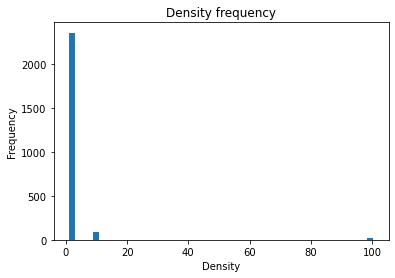

In [462]:
plt.hist(dataset["density"], bins=50)  # TODO(m-jeu): Use OOP API and make clearer
plt.gca().set(title="Density frequency", xlabel="Density", ylabel="Frequency")
plt.show()

As we can see, most measurements fall around the '0.99' mark. Though some fall around the 10, and a couple fall around the 100 mark. We will assume that this is a notation error, where the dots weren't placed right, which can fairly easily be accounted for. If we assume that all measurements are supposed to be around '1', because it wouldn't be realistic for wines to have a 10x or 100x difference in density with others, we can correct for the mistake by recursively dividing the number by 10, until a more sensible measurement is reached.

In [468]:
def divide_until_at(num: float,
                    target: float,
                    divide_by: float,
                    delta: float,
                    max_recursions: int = 0) -> float:
    """Recursively divide a number until it's either within a certain range of a target number,
    or the max number of recursions is reached.

    Args:
        num: input number to divide.
        target: target number to get within a certain range of.
        divide_by: number to divide input number by.
        delta: amount of distance the input number could be from the target number to be considered a success.
        max_recursion: amount of recursion after which the function should give up.

    Returns:
        num divided by divide_by a certain amount of times, so that it's within delta of target.
        amount of times num is divided can also be 0.
        None if max_recursions gets violated."""
    if max_recursions < 0:
        return None
    if abs(num - target) < delta:
        return num
    return divide_until_at((num / divide_by), target, divide_by, delta, (max_recursions - 1))

dataset["density"] = dataset["density"].apply(lambda x: divide_until_at(x, 1, 10, 0.1, 2))
dataset["density"].describe()

count    2464.000000
mean        0.996824
std         0.001870
min         0.990070
25%         0.995687
50%         0.996800
75%         0.997900
max         1.003690
Name: density, dtype: float64

In [470]:
simple_describe(dataset["density"], "Density")

Density:
min: 0.99007
max: 1.00369
#(nan): 1


The weird numbers have been taken care of. A single not-a-number entry remains. Let's have a look:

In [471]:
dataset.loc[dataset["density"].isnull()][['id', 'title', 'density', 'raw_density']]

,id,title,density,raw_density
1474,1475,Howard's Folly 2011 Sonhador Red (Alentejano),NaN,.


A single wine has a density of '.', which we can't really use for anything. To keep the data pure, let's drop it.

In [472]:
dataset = dataset[dataset["density"].notna()]
simple_describe(dataset["density"], "Density")

Density:
min: 0.99007
max: 1.00369
#(nan): 0


Density is clean!

<h4>Alcohol</h4>

Most alcohol percentages are formatted like proper floats, and can be converted automatically. This allows us to analyse the actual numbers as well:

In [443]:
dataset["alcohol"] = pd.to_numeric(dataset["alcohol"], errors='coerce')  # No OOP interface.
simple_describe(dataset["alcohol"], "Alcohol")

Alcohol:
min: 8.5
max: 14.9
#(nan): 10


The alcohol-percentages we have been able to extract from the String objects seem to fall within the boundaries of what could reasonably be considered 'wine'. We are still left with 10 not-a-numbers entries where pandas wasn't able to convert the strings to numbers. Let's have a look at them.

In [444]:
dataset.loc[dataset["alcohol"].isnull()][['id', 'title', 'designation', 'alcohol']]  # TODO(m-jeu): This can probably be made prettier

,id,title,designation,alcohol
1344,1345,Companhia das Quintas 2009 Herdade da Farizoa ...,Herdade da Farizoa Grand Escolha,NaN
1345,1346,Companhia das Quintas 2009 Quinta da Fronteira...,Quinta da Fronteira Selec��o do En�logo,NaN
1620,1621,Quinta das Bandeiras 2013 Passagem Reserva Red...,Passagem Reserva,NaN
1670,1671,Quinta da Rede 2015 Reserva Red (Douro),Reserva,NaN
1764,1765,Terra Silvestre 2014 B�toreus Selection Red (T...,B�toreus Selection,NaN
1765,1766,Adega Cooperativa de Borba 2013 Reserva Red (A...,Reserva,NaN
1766,1767,Adega Cooperativa do Cartaxo 2012 Brid�o Class...,Brid�o Classico,NaN
1794,1795,Quinta da Lagoalva de Cima 2015 Lagoalva Barre...,Lagoalva Barrel Selection,NaN
1795,1796,Quinta do Casal Branco 2014 Lobo e Falc�o Rese...,Lobo e Falc�o Reserva,NaN
2028,2029,Ramos-Pinto 2006 Duas Quintas Reserva Red (Douro),Duas Quintas Reserva,NaN


Considering only 10 wines are missing data, we can probably look these up by hand. The percentages are based on these sources:

<a href="https://www.internationalwinechallenge.com/canopy/beverage_details?wid=44074">1344. </a><a href="https://www.winemag.com/buying-guide/companhia-das-quintas-2009-quinta-da-fronteira-seleccao-do-enologo-red-douro/">1345. </a><a href="https://www.winemag.com/buying-guide/quinta-das-bandeiras-2010-passagem-reserva-red-douro/">1620. </a><a href="https://www.nataliemaclean.com/wine-reviews/quinta-da-rede-reserva-2015/317025">1670. </a><a href="https://www.winemag.com/buying-guide/terra-silvestre-2014-grande-reserva-red-tejo-portuguese-red/">1764. </a><a href="https://www.vivino.com/NL/en/adega-cooperativa-de-borba-alentejo-reserva-tinto/w/1235048?year=2013">1765. </a><a href="https://www.winemag.com/buying-guide/adega-cooperativa-cartaxo-2012-bridao-classico-red-tejo/">1766. </a><a href="https://www.winemag.com/buying-guide/quinta-da-lagoalva-de-cima-2015-lagoalva-barrel-selection-red-tejo/">1794. </a><a href="https://www.winemag.com/buying-guide/quinta-do-casal-branco-2014-lobo-e-falcao-reserva-red-tejo/">1795. </a><a href="https://www.wine-searcher.com/find/ramos+pinto+duas+quinta+rsrv+douro+portugal/2006/netherlands#t2">2028. </a>


In [445]:
# Assignments use numeric row index, and not 'id' column. Might break when working on the id column.
dataset.loc[1344, "alcohol"] = 14.0
dataset.loc[1345, "alcohol"] = 14.5
dataset.loc[1620, "alcohol"] = 14.0
dataset.loc[1670, "alcohol"] = 13.5
dataset.loc[1764, "alcohol"] = 13.5
dataset.loc[1765, "alcohol"] = 14.0
dataset.loc[1766, "alcohol"] = 14.0
dataset.loc[1794, "alcohol"] = 14.0
dataset.loc[1795, "alcohol"] = 14.0
dataset.loc[2028, "alcohol"] = 14.0

Lets' have a look how many nan entries are left in the alcohol column:

In [446]:
dataset["alcohol"].isnull().sum()

0

(Some other things to look at for later:)

In [447]:
dataset["variety"].value_counts()

Portuguese Red    2465
Name: variety, dtype: Int64

In [448]:
dataset["country"].value_counts()

Portugal    2465
Name: country, dtype: Int64

In [449]:
dataset["winery"].value_counts()

Wines & Winemakers       84
Casa Santos Lima         82
DFJ Vinhos               77
Companhia das Quintas    53
Casca Wines              50
                         ..
Quinta da Casaboa         1
Pedra Cancela             1
Caves Campelo             1
Anselmo Mendes            1
Quinta do Vale Brag�o     1
Name: winery, Length: 310, dtype: Int64